In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

def train_nn_with_quality(X, y, quality,
                          hidden_dims,
                          activation='ReLU',
                          lr=1e-3,
                          weight_decay=0.0,
                          epochs=50,
                          batch_size=32):
    """
    Train a feed-forward NN, sampling each batch with probability
    proportional to quality = F2 + F3.
    """
    # Build model
    act_cls = getattr(torch.nn, activation)
    layers = []
    in_dim = X.shape[1]
    for h in hidden_dims:
        layers += [torch.nn.Linear(in_dim, h), act_cls()]
        in_dim = h
    layers.append(torch.nn.Linear(in_dim, 1))
    model = torch.nn.Sequential(*layers)
    
    # Prepare dataset
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # Compute sample weights proportional to F2 + F3
    quality_sums = quality.sum(axis=1)               # shape (N,)
    # To avoid zero probability, add a small epsilon if needed
    sample_weights = quality_sums / quality_sums.sum()
    sample_weights = torch.from_numpy(sample_weights).float()
    
    # Create WeightedRandomSampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler
    )
    
    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn   = torch.nn.MSELoss()
    
    # Training loop
    loss_history = []
    model.train()
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(dataset)
        loss_history.append(epoch_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  MSE={epoch_loss:.4f}")
    
    # Plot loss curve
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(np.arange(1, epochs+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss with Quality Sampling')
    plt.show()
    
    return model, loss_history


In [2]:
from data_preprocessing import preprocess_data
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/test_data_nn(SampleData_07032025_vf3)_cleaned.csv'
X, y, quality, scaler_X, scaler_y = preprocess_data(csv_path)

Epoch   1/100  MSE=1.8982
Epoch  10/100  MSE=0.8145
Epoch  20/100  MSE=0.2500
Epoch  30/100  MSE=0.1252
Epoch  40/100  MSE=0.1465
Epoch  50/100  MSE=0.0573
Epoch  60/100  MSE=0.0634
Epoch  70/100  MSE=0.0383
Epoch  80/100  MSE=0.0386
Epoch  90/100  MSE=0.0449
Epoch 100/100  MSE=0.0538


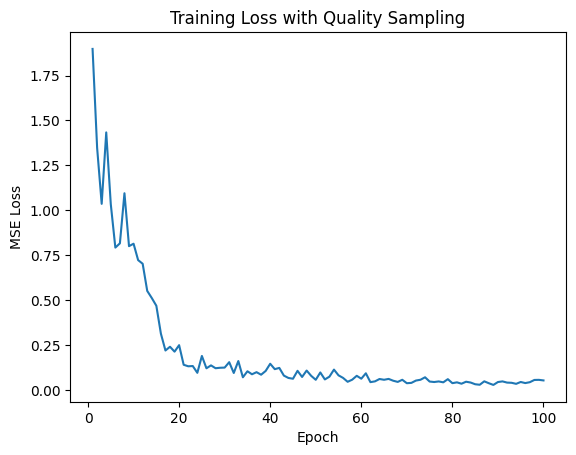

In [3]:
# After preprocessing:
# X, y, quality, scaler_X, scaler_y = preprocess_data(clean_csv_path)

model, losses = train_nn_with_quality(
    X, y, quality,
    hidden_dims   = [8, 8],
    activation    = 'ReLU',
    lr            = 1e-3,
    weight_decay  = 1e-5,
    epochs        = 100,
    batch_size    = 8
)
